Different SCM approaches:
- Synthetic Control Method (Abadie & Gardeazabal 2003)
- Robust Synthetic Control Method (Amjad, Shah & Shen 2018)
- Augmented Synthetic Control Method (Ben-Michael, Feller & Rothstein 2021)
- Penalized Synthetic Control Method (Abadie & L'Hour 2021)
- Generalized Synthetic Control Method 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pysyncon import Dataprep, Synth, AugSynth, PenalizedSynth, RobustSynth
from pysyncon.utils import PlaceboTest
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages

In [11]:

#data
#source -> World Bank Open Data
world_data_FTR = pd.read_csv("/Users/manuelgoncalves/Documents/GitHub/scm-inference-fertility-policies/data/TFR/world_data_TFR.csv").drop(['Country Code', 'Indicator Name', 'Indicator Code', '2023', 'Unnamed: 68'],axis=1)
world_data_educ = pd.read_csv("/Users/manuelgoncalves/Documents/GitHub/scm-inference-fertility-policies/data/Educational attainment, at least completed post-secondary, population 25+, female/world_data_educational_attainment.csv").drop(['Country Code', 'Indicator Name', 'Indicator Code', '2023', 'Unnamed: 68'],axis=1)
world_data_gdp = pd.read_csv("/Users/manuelgoncalves/Documents/GitHub/scm-inference-fertility-policies/data/GDP_per_capita_PPP/GDP_per_capita_PPP.csv").drop(['Country Code', 'Indicator Name', 'Indicator Code', '2023', 'Unnamed: 68'],axis=1)
world_data_inflation = pd.read_csv("//Users/manuelgoncalves/Documents/GitHub/scm-inference-fertility-policies/data/inflation_consumer_prices/world_data_inflation_consumer_prices.csv").drop(['Country Code', 'Indicator Name', 'Indicator Code', '2023', 'Unnamed: 68'],axis=1)
world_data_female_labour = pd.read_csv("/Users/manuelgoncalves/Documents/GitHub/scm-inference-fertility-policies/data/ratio_female_to_male_labor/world_data_ratio_female_to_male_labor.csv").drop(['Country Code', 'Indicator Name', 'Indicator Code', '2023', 'Unnamed: 68'],axis=1)
world_data_unemployment = pd.read_csv("/Users/manuelgoncalves/Documents/GitHub/scm-inference-fertility-policies/data/unemployment_rate_total_percentage/world_data_unemployment_rate_total_percentage.csv").drop(['Country Code', 'Indicator Name', 'Indicator Code', '2023', 'Unnamed: 68'],axis=1)
world_data_urban_population = pd.read_csv("/Users/manuelgoncalves/Documents/GitHub/scm-inference-fertility-policies/data/urban_population_rate/world_data_urban_population_rate.csv").drop(['Country Code', 'Indicator Name', 'Indicator Code', '2023', 'Unnamed: 68'],axis=1)


#melt the data to long format for easier plotting
world_data_FTR = world_data_FTR.melt(
    id_vars=["Country Name"], 
    var_name="Year", 
    value_name="Fertility Rate"
)

world_data_educ = world_data_educ.melt(
    id_vars=["Country Name"], 
    var_name="Year", 
    value_name="Educational Attainment Female"
)

world_data_gdp = world_data_gdp.melt(
    id_vars=["Country Name"], 
    var_name="Year", 
    value_name="GDP per capita PPP"
)

world_data_inflation = world_data_inflation.melt(
    id_vars=["Country Name"], 
    var_name="Year", 
    value_name="Inflation consumer prices"
)

world_data_female_labour = world_data_female_labour.melt(
    id_vars=["Country Name"], 
    var_name="Year", 
    value_name="Female to labour force participation"
)

world_data_unemployment = world_data_unemployment.melt(
    id_vars=["Country Name"], 
    var_name="Year", 
    value_name="Unemployment Rate"
)

world_data_urban_population = world_data_urban_population.melt(
    id_vars=["Country Name"], 
    var_name="Year", 
    value_name="Urban Population Rate"
)

#convert "Year" to numeric for proper sorting
world_data_FTR["Year"] = pd.to_numeric(world_data_FTR["Year"], errors='coerce')
world_data_educ["Year"] = pd.to_numeric(world_data_educ["Year"], errors='coerce')
world_data_gdp["Year"] = pd.to_numeric(world_data_gdp["Year"], errors='coerce')
world_data_inflation["Year"] = pd.to_numeric(world_data_inflation["Year"], errors='coerce')
world_data_female_labour["Year"] = pd.to_numeric(world_data_female_labour["Year"], errors='coerce')
world_data_unemployment["Year"] = pd.to_numeric(world_data_unemployment["Year"], errors='coerce')
world_data_urban_population["Year"] = pd.to_numeric(world_data_urban_population["Year"], errors='coerce')

#aggregate dataframes
# world_data = pd.concat([world_data_FTR, world_data_educ,world_data_gdp,world_data_inflation,world_data_female_labour,world_data_unemployment,
#                         world_data_urban_population])

world_data = world_data_FTR.copy()
world_data = world_data.merge(world_data_educ, on=["Country Name", "Year"], how="left")
world_data = world_data.merge(world_data_gdp, on=["Country Name", "Year"], how="left")
world_data = world_data.merge(world_data_inflation, on=["Country Name", "Year"], how="left")
world_data = world_data.merge(world_data_female_labour, on=["Country Name", "Year"], how="left")
world_data = world_data.merge(world_data_unemployment, on=["Country Name", "Year"], how="left")
world_data = world_data.merge(world_data_urban_population, on=["Country Name", "Year"], how="left")

#filter for relevant countries (donor pool and Germany) & specify time frame
relevant_countries = [
   "Germany", "Portugal", "Switzerland", "Belgium", "Spain", "Italy", "Netherlands", "Ireland", "Slovenia"
]

donor_pool = ["Portugal", "Switzerland", "Belgium", "Spain", "Italy", "Netherlands", "Ireland", "Slovenia"]

world_data = world_data[world_data['Country Name'].isin(relevant_countries)]
world_data = world_data[world_data['Year'].isin(range(1995, 2015))]

print(world_data.duplicated(subset=["Country Name", "Year"]).sum())

0


In [8]:
world_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,180.0,2004.500000,5.782366,1995.000000,1999.750000,2004.500000,2009.250000,2014.000000
Fertility Rate,180.0,1.506722,0.232405,1.130000,1.340000,1.450000,1.687500,2.060000
Educational Attainment Female,72.0,25.111482,9.844155,9.100000,15.705000,25.825000,28.980000,53.163265
GDP per capita PPP,180.0,32056.653941,10290.702885,13628.198078,24672.844271,30663.637045,37883.975434,63417.043716
Inflation consumer prices,180.0,2.326238,2.001187,-4.447547,1.252734,2.076097,2.899495,13.463730
Female to labour force participation,180.0,74.000046,7.708040,53.884712,69.137297,76.044981,80.365610,83.663939
Unemployment Rate,180.0,8.294867,4.509175,2.119000,4.979250,7.439000,9.805500,26.094000
Urban Population Rate,180.0,71.388789,13.435410,50.622000,60.408250,73.517000,77.182500,97.833000


In [9]:
display(world_data[world_data['Country Name']=='Portugal'][["Country Name","Fertility Rate","Year"]])

,Country Name,Fertility Rate,Year
9504,Portugal,1.41,1995
9770,Portugal,1.44,1996
10036,Portugal,1.47,1997
10302,Portugal,1.47,1998
10568,Portugal,1.50,1999
10834,Portugal,1.55,2000
11100,Portugal,1.45,2001
11366,Portugal,1.46,2002
11632,Portugal,1.44,2003
11898,Portugal,1.40,2004


In [12]:
dataprep = Dataprep(
    foo=world_data,
    predictors=[#"Educational Attainment Female",
                "GDP per capita PPP",
                "Inflation consumer prices",
                "Female to labour force participation",
                "Unemployment Rate",
                "Urban Population Rate"
                ],
    predictors_op="mean",
    time_predictors_prior=range(1995, 2007),
    special_predictors=[
        ("Fertility Rate", [2000], "mean"),
        ("Fertility Rate", [2001], "mean"),
        ("Fertility Rate", [2003], "mean"),
        ("Fertility Rate", [2004], "mean"),
        ("Fertility Rate", [2005], "mean"),
        ("Fertility Rate", [2006], "mean"),
        ],
    dependent="Fertility Rate",
    unit_variable="Country Name",
    time_variable="Year",
    treatment_identifier="Germany",
    controls_identifier=donor_pool,
    time_optimize_ssr=range(1995, 2007),
)

print(dataprep)

Dataprep
Treated unit: Germany
Dependent variable: Fertility Rate
Control units: Portugal, Switzerland, Belgium, Spain, Italy, Netherlands, Ireland, Slovenia
Time range in data: 1995 - 2014
Time range for loss minimization: range(1995, 2007)
Time range for predictors: range(1995, 2007)
Predictors: GDP per capita PPP, Inflation consumer prices, Female to labour force participation, Unemployment Rate, Urban Population Rate
Special predictors:
    `Fertility Rate` over `[2000]` using `mean`
    `Fertility Rate` over `[2001]` using `mean`
    `Fertility Rate` over `[2003]` using `mean`
    `Fertility Rate` over `[2004]` using `mean`
    `Fertility Rate` over `[2005]` using `mean`
    `Fertility Rate` over `[2006]` using `mean`



In [13]:
synth = Synth()
synth.fit(dataprep=dataprep,
          optim_method="BFGS", 
          optim_initial="ols",
          )

synth.weights(threshold=0.01)

Portugal       0.137
Switzerland    0.441
Spain          0.418
Name: weights, dtype: float64

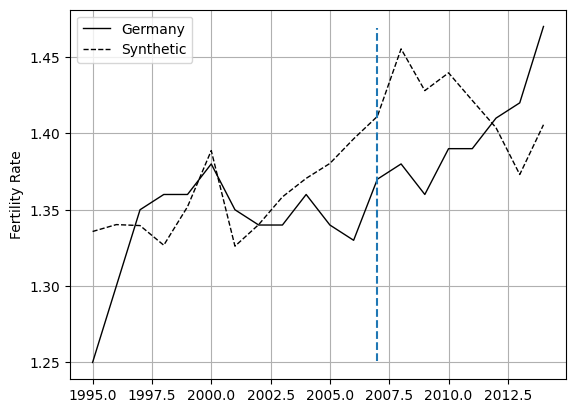

In [14]:
synth.path_plot(time_period=range(1995, 2015), treatment_time=2007)

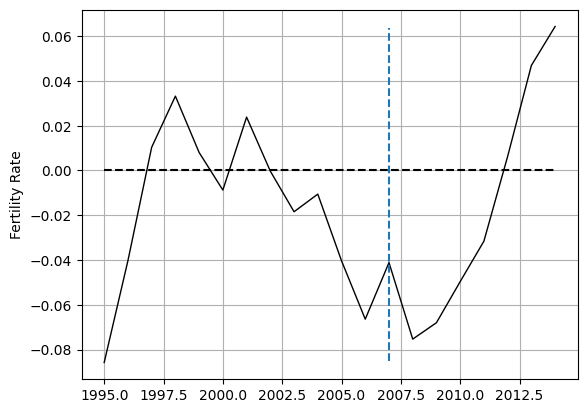

In [15]:
synth.gaps_plot(time_period=range(1995, 2015), treatment_time=2007)

In [16]:
synth.att(time_period=range(1995, 2014))

{'att': -0.021460472684845744, 'se': 0.008774414294675974}

In [17]:
synth.summary()

,V,treated,synthetic,sample mean
GDP per capita PPP,0.165,28263.718,28333.026,26885.179
Inflation consumer prices,0.090,1.438,2.144,2.979
Female to labour force participation,0.100,73.826,70.062,70.487
Unemployment Rate,0.120,9.302,8.483,7.441
Urban Population Rate,0.023,75.061,72.069,69.649
special.1.Fertility Rate,0.040,1.380,1.389,1.509
special.2.Fertility Rate,0.016,1.350,1.326,1.480
special.3.Fertility Rate,0.060,1.340,1.358,1.500
special.4.Fertility Rate,0.006,1.360,1.371,1.511
special.5.Fertility Rate,0.182,1.340,1.380,1.511


In [18]:
placebo_test = PlaceboTest()
placebo_test.fit(
    dataprep=dataprep,
    scm=synth,
    scm_options={"optim_method": "Nelder-Mead", "optim_initial": "equal"},
)

(1/8) Completed placebo test for Ireland.
(2/8) Completed placebo test for Spain.
(3/8) Completed placebo test for Slovenia.
(4/8) Completed placebo test for Italy.
(5/8) Completed placebo test for Belgium.
(6/8) Completed placebo test for Netherlands.
(7/8) Completed placebo test for Switzerland.
(8/8) Completed placebo test for Portugal.
Calculating treated unit gaps.
Done.


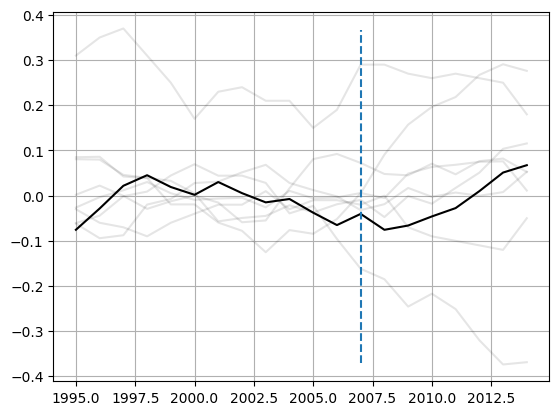

In [19]:
placebo_test.gaps_plot(
    time_period=range(1955, 2015), treatment_time=2007
)

In [20]:
#Augmented Synthetic Control Method
augsynth = AugSynth()
augsynth.fit(dataprep=dataprep)

In [21]:
augsynth.weights()

Portugal       0.322
Switzerland    0.585
Belgium       -0.175
Spain          0.833
Italy         -0.460
Netherlands    0.159
Ireland       -0.091
Slovenia      -0.173
Name: weights, dtype: float64

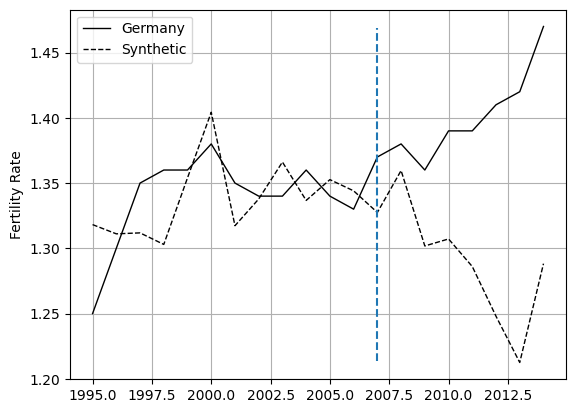

In [22]:
augsynth.path_plot(time_period=range(1995, 2015), treatment_time=2007)

(1/8) Completed placebo test for Switzerland.
(2/8) Completed placebo test for Belgium.
(3/8) Completed placebo test for Ireland.
(4/8) Completed placebo test for Portugal.
(5/8) Completed placebo test for Spain.
(6/8) Completed placebo test for Italy.
(7/8) Completed placebo test for Slovenia.
(8/8) Completed placebo test for Netherlands.
Calculating treated unit gaps.
Done.


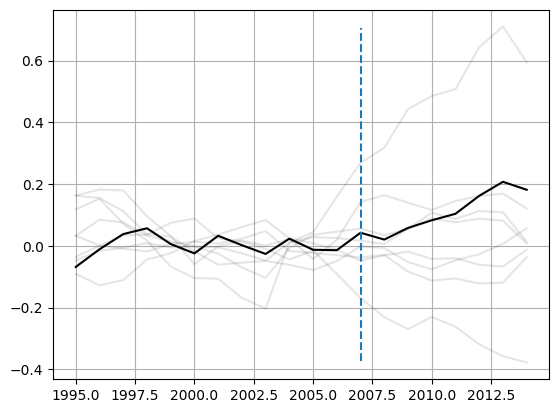

In [25]:
placebo_test_Aug = PlaceboTest()
placebo_test_Aug.fit(
    dataprep=dataprep,
    scm=augsynth
)

placebo_test_Aug.gaps_plot(
    time_period=range(1955, 2015), treatment_time=2007
)

In [26]:
pen = PenalizedSynth()
pen.fit(dataprep, lambda_=0.01)

In [27]:
pen.weights()


Portugal       0.112
Switzerland    0.470
Belgium        0.000
Spain          0.417
Italy          0.000
Netherlands    0.000
Ireland        0.000
Slovenia       0.000
Name: weights, dtype: float64

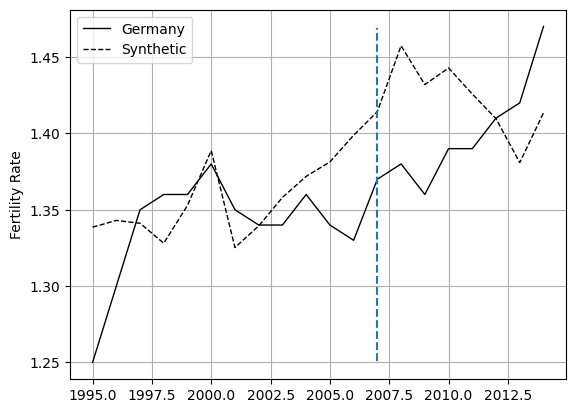

In [28]:
pen.path_plot(time_period=range(1995, 2015), treatment_time=2007)

In [119]:
robust = RobustSynth()
robust.fit(dataprep, lambda_=0.1, sv_count=2)

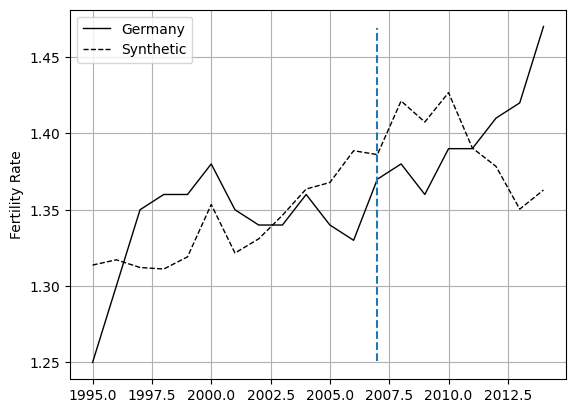

In [120]:
robust.path_plot(time_period=range(1995, 2015), treatment_time=2007)

In [128]:
utils = rpackages.importr("utils")
utils.install_packages("gsynth")

# Activate pandas2ri for seamless conversion
pandas2ri.activate()

# Load gsynth in R
gsynth = importr("gsynth")

# Convert your DataFrame to R
world_data_r = pandas2ri.py2rpy(world_data)

# Run the gsynth model
model = gsynth.gsynth(
    formula=ro.Formula("Fertility.Rate ~ treatment + GDP.per.capita.PPP + "
                       "Inflation.consumer.prices + Female.to.labour.force.participation + "
                       "Unemployment.Rate + Urban.Population.Rate"),
    data=world_data_r,
    index=("Country.Name", "Year"),
    force="two-way",
    CV=True,
    r=(0, 5),
    se=True,
    inference="parametric"
)

# Print summary and visualize in R
ro.r.summary(model)
ro.r.plot(model)

--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (MB) [https]
12: Canada (ON 1) [https]
13: Canada (ON 2) [https]
14: Chile (Santiago) [https]
15: China (Beijing 2) [https]
16: China (Beijing 3) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Jinan) [https]
20: China (Lanzhou) [https]
21: China (Nanjing) [https]
22: China (Shanghai 2) [https]
23: China (Shenzhen) [https]
24: China (Wuhan) [https]
25: Colombia (Cali) [https]
26: Costa Rica [https]
27: Cyprus [https]
28: Czech Republic [https]
29: Denmark [https]
30: East Asia [https]
31: Ecuador (Cuenca) [https]
32: France (Lyon 1) [https]
33: France (Lyon 2) [https]
34: France (Marseille) 